In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORK_PROJECT_NAME, api_key_value=config.HOPSWORK_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-05-10 16:02:22,965 INFO: Initializing external client
2025-05-10 16:02:22,965 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-10 16:02:25,161 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214680


In [4]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1214680/fs/1203298/fv/citibike_hourly_feature_view/version/1
Feature view 'citibike_hourly_feature_view' (version 1) created successfully.
Feature view 'citibike_hourly_feature_view' (version 1) retrieved successfully.


In [5]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly citibike rides",
    read_options={"timeout": 600}
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (31.54s) 


In [6]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [7]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2024-01-01 00:00:00+00:00,190 Morgan,0
1,2024-01-01 01:00:00+00:00,190 Morgan,0
2,2024-01-01 02:00:00+00:00,190 Morgan,0
3,2024-01-01 03:00:00+00:00,190 Morgan,0
4,2024-01-01 04:00:00+00:00,190 Morgan,0


In [8]:
ts_data["pickup_hour"].min()

'2024-01-01 00:00:00+00:00'

In [9]:
ts_data["pickup_hour"].max()

'2024-12-31 23:00:00+00:00'

In [10]:
ts_data_copy = ts_data.copy()

In [11]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [12]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  object             
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(1), object(1)
memory usage: 95.4+ MB


In [13]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [14]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  object        
 2   rides               int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 95.4+ MB


In [15]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [16]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2024-01-01 00:00:00,190 Morgan,0,2024-01
1,2024-01-01 01:00:00,190 Morgan,0,2024-01
2,2024-01-01 02:00:00,190 Morgan,0,2024-01
3,2024-01-01 03:00:00,190 Morgan,0,2024-01
4,2024-01-01 04:00:00,190 Morgan,0,2024-01
...,...,...,...,...
4999995,2024-03-09 21:00:00,4759.02,0,2024-03
4999996,2024-03-10 08:00:00,4759.02,3,2024-03
4999997,2024-03-10 10:00:00,4759.02,0,2024-03
4999998,2024-03-11 09:00:00,4759.02,1,2024-03


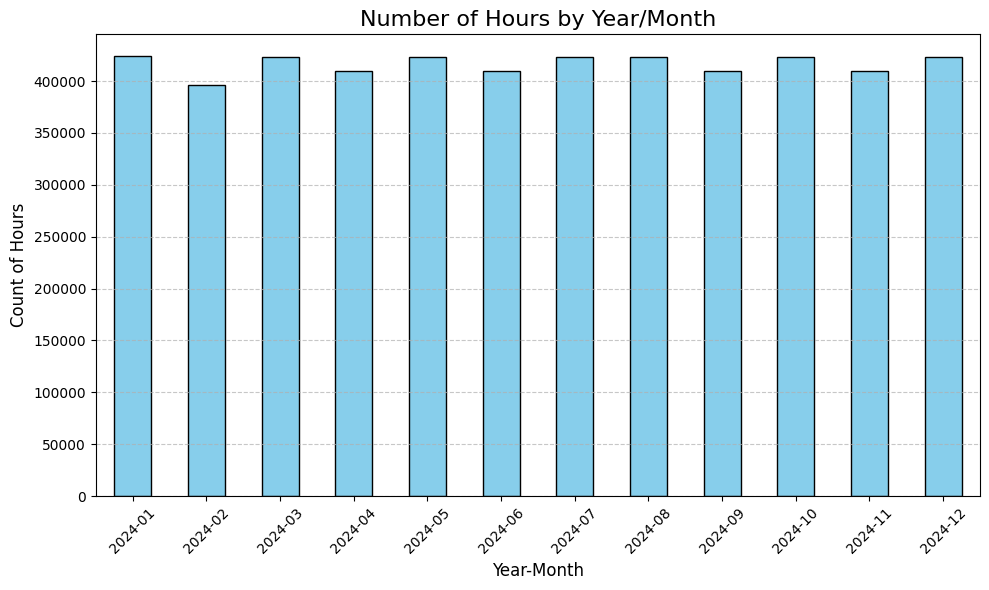

In [17]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [18]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2024-01-01 00:00:00,190 Morgan,0,2024-01
1,2024-01-01 01:00:00,190 Morgan,0,2024-01
2,2024-01-01 02:00:00,190 Morgan,0,2024-01
3,2024-01-01 03:00:00,190 Morgan,0,2024-01
4,2024-01-01 04:00:00,190 Morgan,0,2024-01


In [19]:
gte = ts_data["year_month"] >= pd.Period("2024-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2024-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [20]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [21]:
filtered_data.shape

(5000000, 3)

In [22]:
ts_data = filtered_data

In [23]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  object        
 2   rides               int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 95.4+ MB


In [24]:
ts_data.head()["pickup_hour"].values

array(['2024-01-01T00:00:00.000000000', '2024-01-01T01:00:00.000000000',
       '2024-01-01T02:00:00.000000000', '2024-01-01T03:00:00.000000000',
       '2024-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [29]:
top_locations = (
    ts_data.groupby("pickup_location_id")["rides"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
)
top_locations

pickup_location_id
4395.07    78432
3651.04    68002
4051.01    57305
Name: rides, dtype: int32

In [25]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=24)

Skipping location_id 4759.02: Not enough data to create even one window.


In [26]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-29 00:00:00,190 Morgan
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-30 00:00:00,190 Morgan
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-31 00:00:00,190 Morgan
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-02-01 00:00:00,190 Morgan
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-02-02 00:00:00,190 Morgan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192361,0,1,2,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2024-11-14 03:00:00,4757.06
192362,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,5,0,1,2024-11-25 22:00:00,4757.06
192363,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2024-12-02 09:00:00,4757.06
192364,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-12-14 16:00:00,4757.06


In [33]:
features[features["pickup_location_id"] == "4395.07"]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
144326,3,5,1,2,0,1,0,1,1,2,...,3,2,0,4,3,3,0,1,2024-01-29,4395.07
144327,0,0,0,0,0,0,3,8,16,14,...,7,9,13,6,5,3,5,1,2024-01-30,4395.07
144328,0,1,0,0,1,0,3,9,17,14,...,15,14,7,9,0,5,4,3,2024-01-31,4395.07
144329,4,1,0,0,0,1,2,14,12,8,...,8,13,11,9,7,3,5,2,2024-02-01,4395.07
144330,1,1,0,0,0,1,3,10,19,4,...,12,16,17,13,11,3,6,2,2024-02-02,4395.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144659,1,1,0,0,0,0,2,1,2,4,...,9,8,5,4,5,3,5,0,2024-12-27,4395.07
144660,1,1,0,0,0,0,0,2,1,4,...,7,7,10,10,9,6,5,5,2024-12-28,4395.07
144661,1,1,1,0,0,0,0,0,1,7,...,4,4,6,1,5,1,1,2,2024-12-29,4395.07
144662,0,0,0,0,0,1,12,14,18,10,...,21,18,15,7,4,4,3,7,2024-12-30,4395.07


In [34]:
features_copy = features.copy()

In [35]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(192366, 675)

In [36]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = datetime(2024, 10, 1, 0, 0, 0)  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

datetime.datetime(2024, 10, 1, 0, 0)

In [37]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(140026, 674)
(140026,)
(52340, 674)
(52340,)


In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140026 entries, 0 to 140025
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int64(672), object(1)
memory usage: 720.0+ MB


In [39]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [40]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.503676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22488
[LightGBM] [Info] Number of data points in the train set: 192366, number of used features: 675
[LightGBM] [Info] Start training from score 0.547243


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x000002C9A4B77520>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [41]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [42]:
predictions

array([0.00243018, 0.00243018, 0.00391133, ..., 0.19225425, 0.47078803,
       0.15367593])

In [43]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

0.5115


In [44]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['F:\\DushyanthData\\Applied_Machine_Learning\\Final_Project\\models\\lgb_model.pkl']

In [45]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [46]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="citibike_rides_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    # include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
model.save("F:\\DushyanthData\\Applied_Machine_Learning\\Final_Project\\models\\lgb_model.pkl")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading F:\DushyanthData\Applied_Machine_Learning\Final_Project\models\lgb_model.pkl: 0.000%|          | 0/3…

Uploading f:\DushyanthData\Applied_Machine_Learning\Final_Project\notebooks\input_example.json: 0.000%|       …

Uploading f:\DushyanthData\Applied_Machine_Learning\Final_Project\notebooks\model_schema.json: 0.000%|        …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214680/models/citibike_rides_demand_predictor_next_hour/1


Model(name: 'citibike_rides_demand_predictor_next_hour', version: 1)

In [50]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-05-10 16:32:57,735 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-10 16:32:57,741 INFO: Initializing external client
2025-05-10 16:32:57,741 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-10 16:32:58,551 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214680


Downloading: 0.000%|          | 0/330679 elapsed<00:00 remaining<?

In [51]:
from src.inference import get_model_predictions

In [52]:
preds = get_model_predictions(model, features_copy)

In [53]:
preds

,pickup_location_id,predicted_demand
0,190 Morgan,0.0
1,190 Morgan,0.0
2,190 Morgan,0.0
3,190 Morgan,0.0
4,190 Morgan,0.0
...,...,...
192361,4757.06,0.0
192362,4757.06,1.0
192363,4757.06,0.0
192364,4757.06,0.0


In [54]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

0.4466
